## Part 1: Building a Random Forest Model

In this coding example, we will tackle the business problem of Loan Classification with a Random Forest Model.

### Dataset and Preprocessing

The dataset that we'll be using comes from the U.S. Small Business Administration (SBA). Founded in 1953, SBA strives to guarantee loans for small enterprises in the U.S. credit market to create more job opportunities and reduce unemployment. In this large-scale dataset, we will use the characteristics of previous loan records to perform a binary classification of loan status (approved or denied). Considering the complexity of the original dataset, we will select only a portion of the provided features for this demo. You are encouraged to look through the full dataset and descriptions: https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
# Load the SBA loan data and make a copy for exploration
df = pd.read_csv('./SBAnational.csv', low_memory=False).drop(columns = ['Term', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'FranchiseCode', 'ChgOffDate', 'DisbursementDate', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'])

The features that we will be using include:

| Variable Name | Description |
| --- | --- | 
| NoEmp	| Number of business employees |
| NewExist | 1 = Existing business, 2 = New business |
| CreateJob	| Number of jobs created |
| RetainedJob | Number of jobs retained |
| UrbanRural | 1 = Urban, 2 = rural, 0 = undefined |
| RevLineCr | Revolving line of credit: Y = Yes, N = No |
| LowDoc | LowDoc Loan Program: Y = Yes, N = No |
| DisbursementGross | Amount disbursed |
| MIS_Status | Loan status charged off = CHGOFF, Paid in full = PIF |

Here MIS_Status is the target variable that we would like to predict, the remaining 8 features will be our predictors.

As usual, we can use $\texttt{info()}$ to get a quick overview of our data. Since this is a real-world dataset that hasn't been preprocessed, we need to be careful about potential errorneous entries, including but not limited to missing values, invalid/inconsistent labeling, etc.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   NoEmp              899164 non-null  int64  
 1   NewExist           899028 non-null  float64
 2   CreateJob          899164 non-null  int64  
 3   RetainedJob        899164 non-null  int64  
 4   UrbanRural         899164 non-null  int64  
 5   RevLineCr          894636 non-null  object 
 6   LowDoc             896582 non-null  object 
 7   DisbursementGross  899164 non-null  object 
 8   MIS_Status         897167 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 61.7+ MB


For this dataset, we can first observe that there are potential null values for the variable NewExist, RevLineCr, LowDoc, and MIS_Status. For this example, let's take the straightforward approach and drop all entries that have null values.

In [26]:
#Drop all entries with null values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889938 entries, 0 to 899163
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   NoEmp              889938 non-null  int64  
 1   NewExist           889938 non-null  float64
 2   CreateJob          889938 non-null  int64  
 3   RetainedJob        889938 non-null  int64  
 4   UrbanRural         889938 non-null  int64  
 5   RevLineCr          889938 non-null  object 
 6   LowDoc             889938 non-null  object 
 7   DisbursementGross  889938 non-null  object 
 8   MIS_Status         889938 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 67.9+ MB


Next, we need to examine the variables that contain non-numerical data and transform them to a numerical format. Let's first take a look at the variables that involve categorical labeling, i.e. RevLineCr, LowDoc, and MIS_Status.

In [27]:
print("RevLineCr Unique Values:")
print(df['RevLineCr'].value_counts())
print()
print("LowDoc Unique Values:")
print(df['LowDoc'].value_counts())
print()
print("MIS_Status Unique Values:")
print(df['MIS_Status'].value_counts())

RevLineCr Unique Values:
N    417362
0    257431
Y    199893
T     15187
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: RevLineCr, dtype: int64

LowDoc Unique Values:
N    778761
Y    108009
0      1239
C       757
S       602
A       495
R        74
1         1
Name: LowDoc, dtype: int64

MIS_Status Unique Values:
P I F     733502
CHGOFF    156436
Name: MIS_Status, dtype: int64


Looks like we've found an issue! Recall that in the data description RevLineCr and LowDoc were descibed to have either "Y" or "N" values, yet here we see that there are multiple invalid labels present in the data. Again for this example, let's remove all samples that contain these invalid labels.

In [28]:
df = df[((df['RevLineCr'] == "Y") | (df['RevLineCr'] == "N")) & ((df['LowDoc'] == "Y") | (df['LowDoc'] == "N"))]

In [29]:
print("RevLineCr Unique Values:")
print(df['RevLineCr'].value_counts())
print()
print("LowDoc Unique Values:")
print(df['LowDoc'].value_counts())
print()
print("MIS_Status Unique Values:")
print(df['MIS_Status'].value_counts())

RevLineCr Unique Values:
N    414984
Y    199696
Name: RevLineCr, dtype: int64

LowDoc Unique Values:
N    557383
Y     57297
Name: LowDoc, dtype: int64

MIS_Status Unique Values:
P I F     503697
CHGOFF    110983
Name: MIS_Status, dtype: int64


Considering that we also have two numerical variables that indicates categorical info, NewExist and UrbanRural, it makes sense for us to also check and see if the entries are also consistent with their original descriptions, i.e. NewExist should only have values 1 or 2 and UrbanRural should have only values 0,1, or 2.

In [30]:
print("NewExist Unique Values:")
print(df['NewExist'].value_counts())
print()
print("UrbanRural Unique Values:")
print(df['NewExist'].value_counts())

NewExist Unique Values:
1.0    447689
2.0    166034
0.0       957
Name: NewExist, dtype: int64

UrbanRural Unique Values:
1.0    447689
2.0    166034
0.0       957
Name: NewExist, dtype: int64


It seems that NewExist contains irrelevant labels, let's remove those entries from our dataset.

In [31]:
df = df[df['NewExist'] != 0]

In [32]:
print("NewExist Unique Values:")
print(df['NewExist'].value_counts())
print()
print("UrbanRural Unique Values:")
print(df['NewExist'].value_counts())

NewExist Unique Values:
1.0    447689
2.0    166034
Name: NewExist, dtype: int64

UrbanRural Unique Values:
1.0    447689
2.0    166034
Name: NewExist, dtype: int64


Great, now we've removed all of the inconsistencies from the categorical variables. Let's move on to transforming the cleaned non-numerical data to numeric formats. As we've seen in a previous demo, we can apply Integer Encoding to the categorical variables RevLineCr, LowDoc, and MIS_Status, using the $\texttt{factorize()}$ method.

In [33]:
encoded_RevLineCr, labels_RevLineCr = df['RevLineCr'].factorize()
df['encoded_RevLineCr'] = encoded_RevLineCr

encoded_LowDoc, labels_LowDoc = df['LowDoc'].factorize()
df['encoded_LowDoc'] = encoded_LowDoc

encoded_MIS_Status, labels_MIS_Status = df['MIS_Status'].factorize()
df['encoded_MIS_Status'] = encoded_MIS_Status

df.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,encoded_RevLineCr,encoded_LowDoc,encoded_MIS_Status
0,4,2.0,0,0,0,N,Y,"$60,000.00",P I F,0,0,0
1,2,2.0,0,0,0,N,Y,"$40,000.00",P I F,0,0,0
2,7,1.0,0,0,0,N,N,"$287,000.00",P I F,0,1,0
3,2,1.0,0,0,0,N,Y,"$35,000.00",P I F,0,0,0
4,14,1.0,7,7,0,N,N,"$229,000.00",P I F,0,1,0


Now all that is left is the variable DisbursementGross. As we can observe from above, the variable is not categorical and thus does not need encoding. Instead, in order to transform the variable to numerical format, we need to reformat the values to remove non-numerical characters such as "$" and ",". We will do so by defining a formatting function and applying it to the DisbursementGross column.

In [34]:
df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x: float(x.strip().replace("$","").replace(",","")))

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613723 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   NoEmp               613723 non-null  int64  
 1   NewExist            613723 non-null  float64
 2   CreateJob           613723 non-null  int64  
 3   RetainedJob         613723 non-null  int64  
 4   UrbanRural          613723 non-null  int64  
 5   RevLineCr           613723 non-null  object 
 6   LowDoc              613723 non-null  object 
 7   DisbursementGross   613723 non-null  float64
 8   MIS_Status          613723 non-null  object 
 9   encoded_RevLineCr   613723 non-null  int64  
 10  encoded_LowDoc      613723 non-null  int64  
 11  encoded_MIS_Status  613723 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 60.9+ MB


Our dataset is almost ready to go, let's establish the target and predictors and perform the Train/Test Split Protocol with a 8:2 train to test ratio. Optionally, since DisbursementGross is on a largely different scale we can perform feature scaling prior to training. In this demo, we are only considering Tree models. Tree models are optimized based on Information Gain which is not effected by feature scale, hence we'll skip feature scaling. You are encouraged to explore the other unused features in the dataset in more detail.

In [36]:
from sklearn.model_selection import train_test_split

# Establish target and predictors
X = df.drop(['MIS_Status', 'RevLineCr', 'LowDoc', 'encoded_MIS_Status'], axis = 1)
y = df['encoded_MIS_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Tree Pre-Pruning

Tree Pre-Pruning involves stopping the growth of the decision tree before it becomes fully expanded. In this demo, we will conduct pre-pruning by limiting the maximum depth and minimum number of samples. We'll save our conditions into two variables for later use.


In [37]:
max_depth = 20
min_samples_split = 4

### Baseline Model: Decision Tree

We'll use the Decision Tree Classifier model as our baseline to demonstrate the advantage of random forests on complex, large-scale datasets. We'll use accuracy score as our evaluation metric for this classification problem.

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, random_state = 0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=4, random_state=0)

In [39]:
from sklearn.metrics import accuracy_score

y_pred_train = dt_clf.predict(X_train)
train_acc_dt = accuracy_score(y_train, y_pred_train)

y_pred_test = dt_clf.predict(X_test)
test_acc_dt = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_acc_dt)
print("Test Accuracy:", test_acc_dt)

Training Accuracy: 0.8496490677790044
Test Accuracy: 0.8078944152511304


### Random Forest Classifier

Now, let's initialize and train our Random Forest Classifier. For this example, we will initialize the forest with 20 trees, using the same tree pre-pruning conditions for each of the trees in ou forest. Similar to the Decision Tree classifier we will use accuracy score to evaluate model performance.

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth = max_depth, min_samples_split = min_samples_split, n_estimators = 20, random_state = 0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=20,
                       random_state=0)

In [41]:
y_pred_train = rf_clf.predict(X_train)
train_acc_rf = accuracy_score(y_train, y_pred_train)

y_pred_test = rf_clf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_acc_rf)
print("Test Accuracy:", test_acc_rf)

Training Accuracy: 0.8435571451266656
Test Accuracy: 0.816513910953603


## Part 2: Interpreting a Random Forest Model

Similar to Decision Trees, we can visualize the learned Random Forest Model by plotting each of the trees in the forest using the $\texttt{plot\_tree}$ method. Since the trees are quite large, we will only plot the first three layers of the first three learned trees in the forest.

In [42]:
rf_clf.estimators_

[DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=209652396),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=398764591),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=924231285),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=1478610112),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=441365315),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=1537364731),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
                        random_state=192771779),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=4,
               

In [43]:
from sklearn import tree
from matplotlib import pyplot as plt
fn = X.columns.to_list()
cn = ["PIF", "CHGOFF"]
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5), dpi=900)
for index in range(0, 3):
    tree.plot_tree(rf_clf.estimators_[index],
                   max_depth = 2,
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   fontsize = 10,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
plt.show()

As we've seen previously for Decision Trees, a tree model allows us to understand feature importance. For Random Forests, which consists of multiple trees, we no longer have an absolute measure of feature importance. However, we can still have some understanding of feature importance by looking at the mean and standard deviation of the feature importance scores across all trees in the forest. Let's calculate and plot out the mean and standard deviation feature importance scores for all of the features used as predictors.

[0.10503115 0.01341711 0.06434343 0.14318121 0.12869006 0.47670499
 0.04312347 0.02550858]
[0.01601881 0.00261132 0.01058161 0.06743583 0.06721515 0.02308183
 0.01598257 0.02854876]


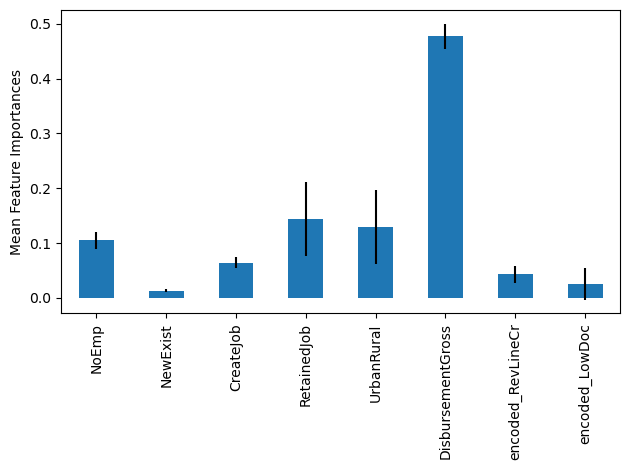

In [44]:
import numpy as np

forest = rf_clf
feature_names = X.columns.to_list()

importances = forest.feature_importances_ #mean
print(importances)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0) #std dev
print(std)
forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean Feature Importances")
fig.tight_layout()